In [1]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# importing ploting libraries
import matplotlib.pyplot as plt 
from scipy.stats import zscore
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn import model_selection

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,KFold
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import roc_auc_score

C:\Users\hp\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('D:\Traina.csv')
test = pd.read_csv('D:\Testa.csv')

In [5]:
train.shape

(1763, 1559)

In [3]:
sc = StandardScaler()

In [4]:
train1 = train.drop(['Class'],axis =1)
y = train['Class']
trains1 = sc.fit_transform(train1)
tests1 = sc.transform(test)

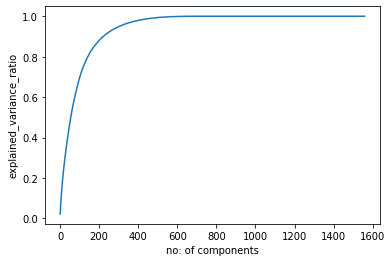

In [6]:
pca = PCA()
train_pca = pca.fit(trains1)
plt.plot(range(1,1559),np.cumsum(train_pca.explained_variance_ratio_))
plt.xlabel('no: of components')
plt.ylabel('explained_variance_ratio')
plt.show()

In [14]:
pca = PCA(0.99)
train_pca = pca.fit_transform(trains1)

In [15]:
train_pca.shape

(1763, 466)

In [18]:
pca = PCA(n_components = 466)

In [19]:
trains1_pca = pca.fit_transform(trains1)
tests_pca = pca.transform(tests1)

In [21]:
rf=RandomForestClassifier(n_estimators = 400, max_depth = 6,criterion = 'entropy')

kfold = KFold(shuffle=True,n_splits=10,random_state=0)
rf_results = cross_val_score(rf, trains1_pca, y,cv=kfold, scoring='roc_auc')
print(np.mean(rf_results))
print(np.std(rf_results,ddof=1))

0.8944591747849
0.060382729639887646


In [24]:
model_rf = rf.fit(trains1_pca, y)
pred_rf = model_rf.predict(tests_pca)

In [25]:
y_rf = pd.DataFrame(pred_rf)
y_rf[0].value_counts()

0    742
1     14
Name: 0, dtype: int64

In [22]:
rf1=RandomForestClassifier()
rf_results1 = cross_val_score(rf1, trains1_pca, y,cv=kfold, scoring='roc_auc')
print(np.mean(rf_results1))
print(np.std(rf_results1,ddof=1))

0.8862165253696819
0.053172208915835385


In [23]:
rf2=RandomForestClassifier(n_estimators = 400, max_depth = 6,criterion = 'gini')

kfold = KFold(shuffle=True,n_splits=10,random_state=0)
rf_results2 = cross_val_score(rf2, trains1_pca, y,cv=kfold, scoring='roc_auc')
print(np.mean(rf_results2))
print(np.std(rf_results2,ddof=1))

0.8855272232797746
0.05555450909482316


In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(trains1_pca,y,test_size=0.3,random_state=42)

In [27]:
from lightgbm import LGBMClassifier
lgb_fit_params={"early_stopping_rounds":500, 
            
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose':100
           }
lgb_params = {'boosting_type': 'gbdt',
 
 'verbose': 0,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'lambda_l1': 0.01,
 'lambda_l2': 0.01,
 'learning_rate': 0.01,
 'max_bin': 255,
 'max_depth': 6,
 'min_data_in_bin': 1,
 'min_data_in_leaf': 1,
 'num_leaves': 31}

In [28]:
lgb = LGBMClassifier(n_estimators=20000, **lgb_params, random_state=123456789, n_jobs=-1)
lgb.fit(X_train, y_train, **lgb_fit_params)
lgb.best_iteration_

Training until validation scores don't improve for 500 rounds
[100]	valid's binary_logloss: 0.221766
[200]	valid's binary_logloss: 0.218139
[300]	valid's binary_logloss: 0.227681
[400]	valid's binary_logloss: 0.243044
[500]	valid's binary_logloss: 0.259584
[600]	valid's binary_logloss: 0.277016
Early stopping, best iteration is:
[165]	valid's binary_logloss: 0.216887


165

In [29]:
clf_lgb=LGBMClassifier(n_estimators=int(lgb.best_iteration_*2.2), **lgb_params)
lgb_model=clf_lgb.fit(trains1_pca, y)

In [30]:
lgb_score=cross_val_score(X=trains1_pca,y=y,estimator=clf_lgb,scoring='roc_auc',cv=kfold)
np.mean(lgb_score)

0.8901827757486667